In [1]:
#Import dependencies
library(BiocStyle)
library(rmarkdown)
library(geneplotter)
library(ggplot2)
library(plyr)
library(LSD)
library(DESeq2)
library(gplots)
library(RColorBrewer)
library(stringr)
library(topGO)
library(genefilter)
library(biomaRt)
library(dplyr)
library(EDASeq)
library(fdrtool)
library(org.Sc.sgd.db)


Attaching package: ‘rmarkdown’

The following objects are masked from ‘package:BiocStyle’:

    html_document, md_document, pdf_document

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames

In [2]:
#Import count matrix
counts_conA <- read.table('/Users/jordan/Desktop/collaborations/casey_collab/processed_data/conA_counts.csv',sep=",", header=TRUE, row.names=1)

head(counts_conA)

,X14517X2,X14517X5,X14517X4,X14517X3,X14517X12,X14517X8,X14517X10,X14517X6,X14517X1,X14517X7,X14517X11,X14517X9
R0010W,0,0,0,0,0,0,0,0,0,0,0,0
R0020C,0,0,0,0,0,0,0,0,0,0,0,0
R0030W,0,0,0,0,0,0,0,0,0,0,0,0
R0040C,0,0,0,0,0,0,0,0,0,0,0,0
YAL068C,0,0,0,0,1,0,1,0,1,0,0,0
YAL067W-A,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
#Import metadata
samples_conA <- read.table('/Users/jordan/Desktop/collaborations/casey_collab/metadata/info_table_deseq.csv', header=TRUE, sep=",")

#Make sample names consistent with R import syntax
samples_conA$Sample <- lapply(samples_conA$Sample, function(x) paste("X", x, sep=""))
                              
head(samples_conA)

Sample,Experiment,Time,Replicate
X14517X1,Concanamycin_A,0,A
X14517X2,Concanamycin_A,0,B
X14517X3,Concanamycin_A,0,C
X14517X4,Concanamycin_A,1,A
X14517X5,Concanamycin_A,1,B
X14517X6,Concanamycin_A,1,C


In [4]:
#Convert time points to factors
samples_conA$Time <- factor(samples_conA$Time, levels = c("0","1","3","6"))

#Run DESeq analysis
dds_conA <- DESeqDataSetFromMatrix(countData = counts_conA, colData = samples_conA, design = ~ Time)
dds_conA <- DESeq(dds_conA)
res_conA <- results(dds_conA)

#Order output by p-adj
resOrdered_conA <- res_conA[order(res_conA$padj),]

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [5]:
write.table(as.data.frame(resOrdered_conA),file='/Users/jordan/Desktop/collaborations/casey_collab/deseq/conA_de.csv', 
            sep=",", col.names=T, row.names=T)

In [6]:
GeneCounts <- counts(dds_conA)
idx.nz <- apply(GeneCounts, 1, function(x) { all(x > 0)})
sum(idx.nz)

[1] 5679

In [7]:
DESeq2Table <- estimateSizeFactors(dds_conA)
sizeFactors(DESeq2Table)

X14517X2  X14517X5  X14517X4  X14517X3 X14517X12  X14517X8 X14517X10  X14517X6 
0.8233819 1.0837470 1.0038578 0.7817696 0.9878281 0.9995098 1.0659362 1.1073362 
 X14517X1  X14517X7 X14517X11  X14517X9 
1.0238275 0.9744761 1.0415177 1.1997209

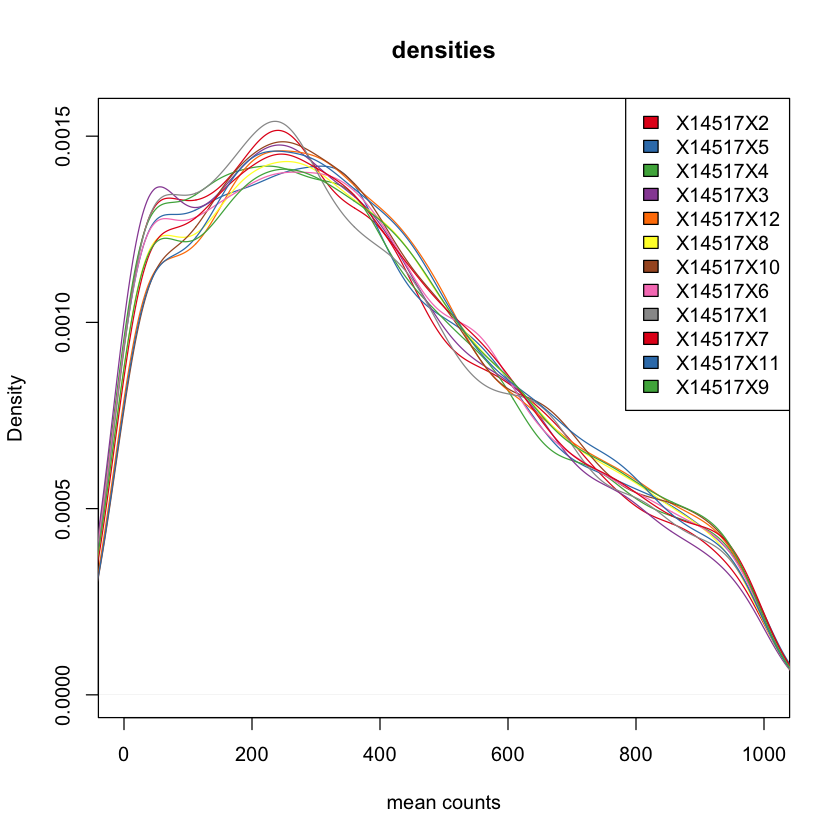

In [8]:
multidensity( counts(DESeq2Table, normalized = T)[idx.nz ,],
    xlab="mean counts", xlim=c(0, 1000))

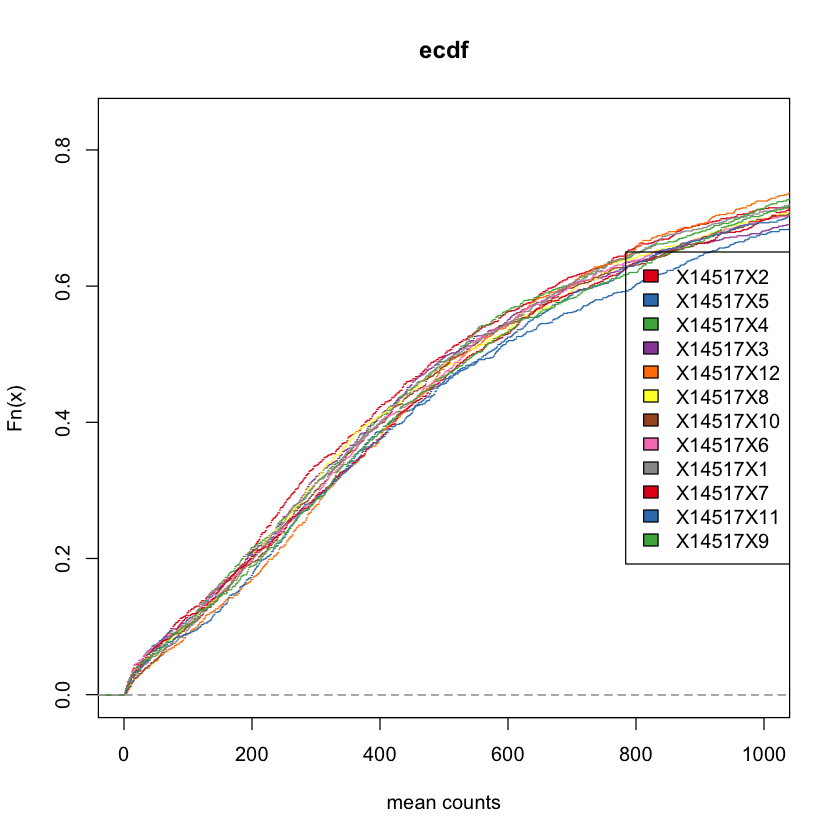

In [9]:
multiecdf( counts(DESeq2Table, normalized = T)[idx.nz ,],
    xlab="mean counts", xlim=c(0, 1000))

In [10]:
pdf("pairwiseMAs.pdf")
  MA.idx = t(combn(1:8, 2))
  for( i in  seq_along( MA.idx[,1])){ 
   MDPlot(counts(DESeq2Table, normalized = T)[idx.nz ,], 
        c(MA.idx[i,1],MA.idx[i,2]), 
    main = paste( colnames(DESeq2Table)[MA.idx[i,1]], " vs ",
     colnames(DESeq2Table)[MA.idx[i,2]] ), ylim = c(-3,3))
    }
dev.off()

pdf 
  2

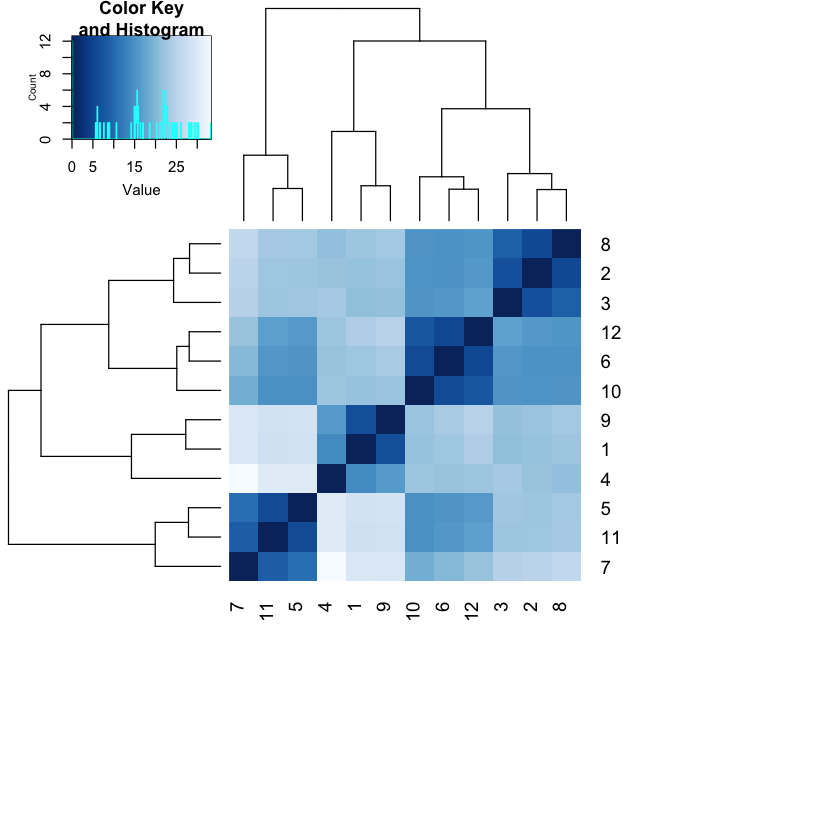

In [11]:
rld <- rlogTransformation(DESeq2Table, blind=TRUE)


distsRL <- dist(t(assay(rld)))
mat <- as.matrix(distsRL)
rownames(mat) <-  colData(rld)$condition
colnames(mat) <-  colData(rld)$sampleNO

hmcol <- colorRampPalette(brewer.pal(9, "Blues"))(255)
heatmap.2(mat, trace="none", col = rev(hmcol), margin=c(13, 13))

found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


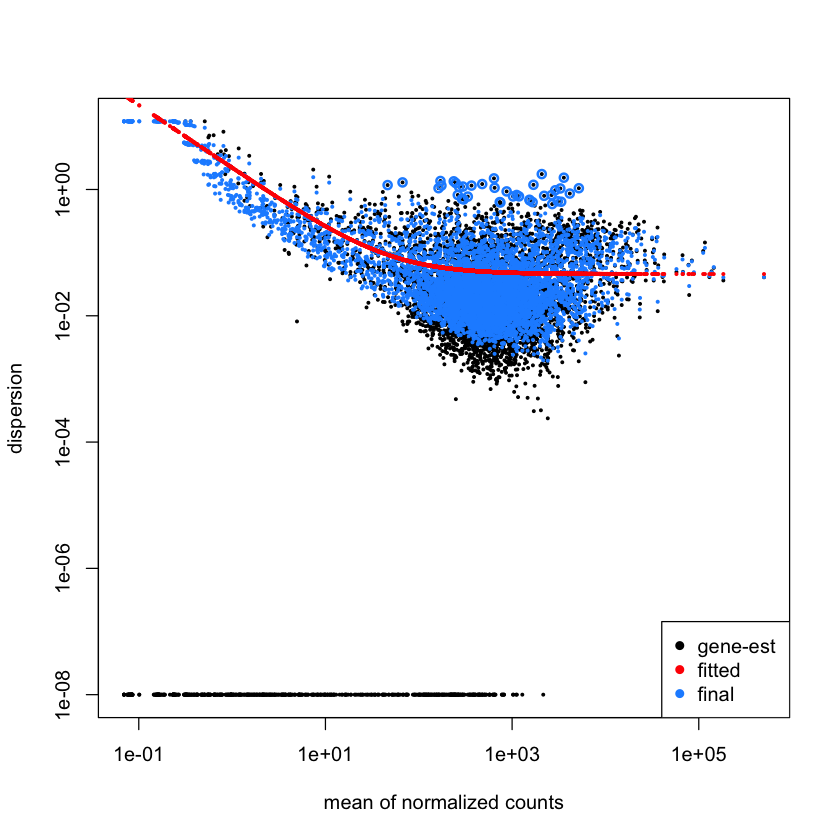

In [12]:
DESeq2Table <- estimateDispersions(DESeq2Table)
plotDispEsts(DESeq2Table)

In [13]:
DESeq2Table <-  nbinomWaldTest(DESeq2Table)
DESeq2Res <- results(DESeq2Table, pAdjustMethod = "BH")

table(DESeq2Res$padj < 0.1)


FALSE  TRUE 
 5463   146 

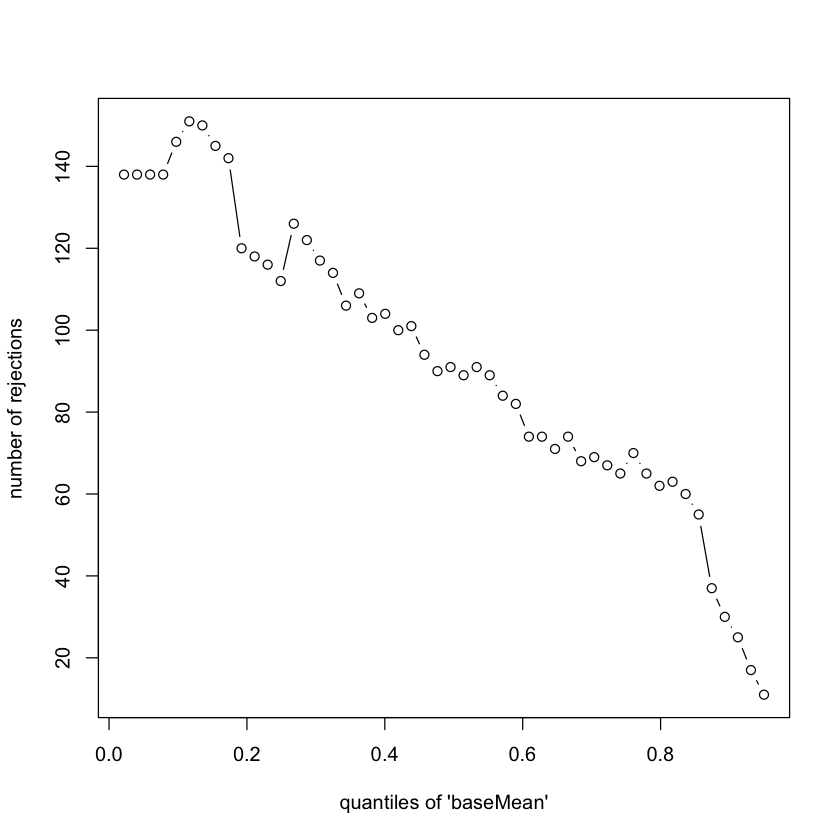

In [14]:
plot(metadata(resOrdered_conA)$filterNumRej, type="b", xlab="quantiles of 'baseMean'",
     ylab="number of rejections")

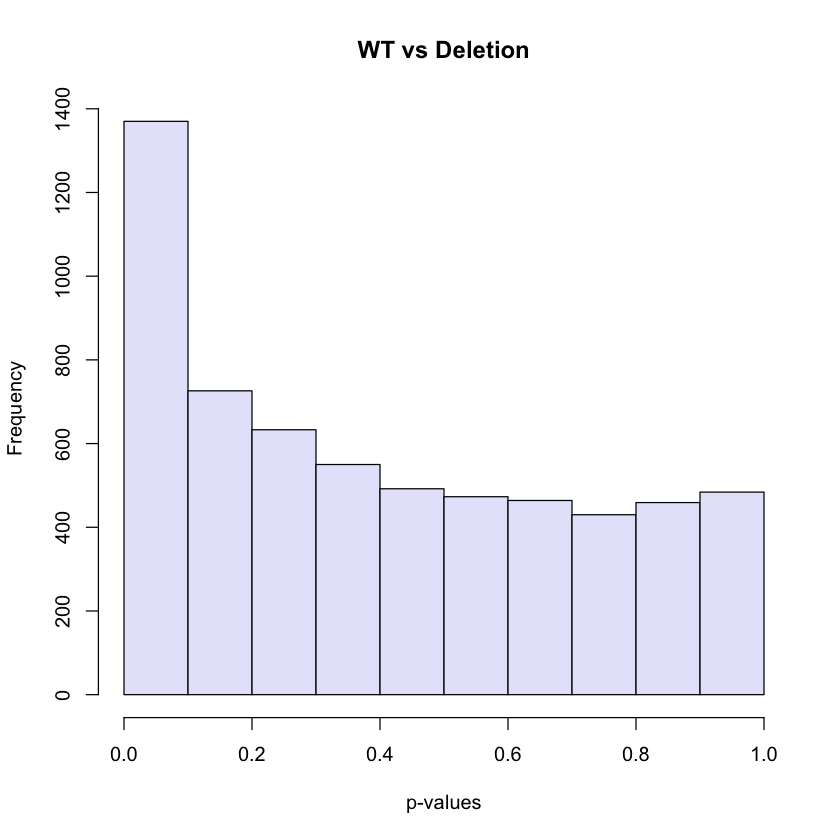

In [15]:
hist(resOrdered_conA$pvalue, col = "lavender", main = "WT vs Deletion", xlab = "p-values")

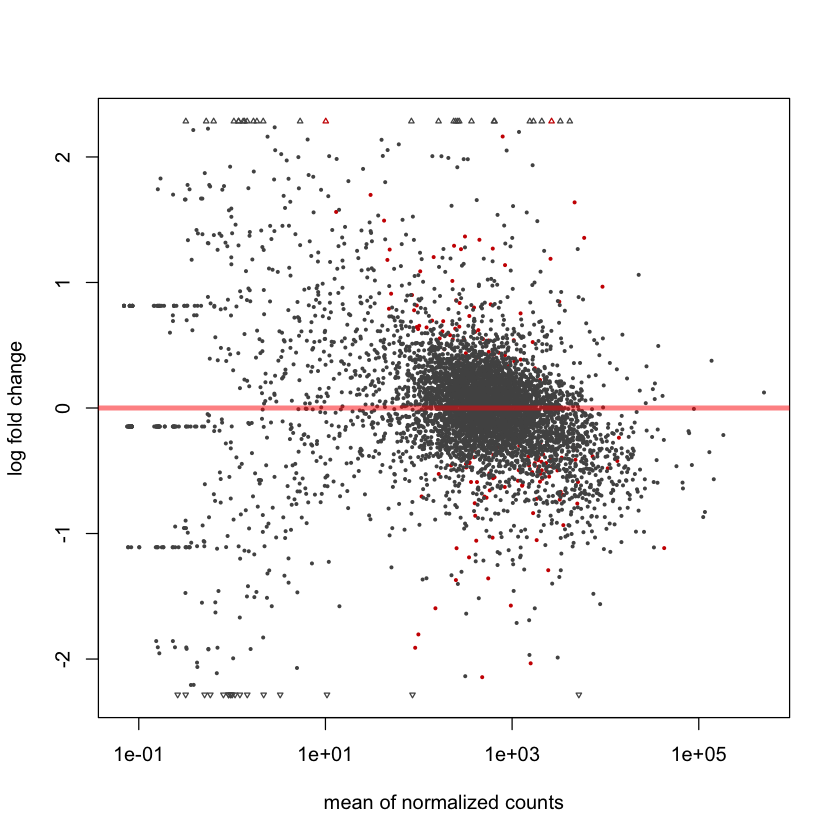

In [16]:
plotMA(resOrdered_conA)

In [47]:
resOrdered_conA.index

ERROR: Error in eval(expr, envir, enclos): object 'resOrdered_conA.index' not found


In [48]:
rowsum.threshold <- 1 # user chosen
fdr.threshold <- 0.1 # user chosen
rs <- rowSums(counts(DESeq2Table))
DESeq2Table <- DESeq2Table[ rs > rowsum.threshold ,]
DESeq2Table <- DESeq(DESeq2Table)
res <- results(DESeq2Table, independentFiltering=FALSE) # use count threshold instead of IF
assayed.genes <- rownames(res)
de.genes <- rownames(res)[ which(res$padj < fdr.threshold) ]

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [51]:
length(de.genes)

[1] 138

[1] "ETS1-1"    "ETS1-2"    "ETS2-1"    "ETS2-2"    "HRA1"      "ICR1"     
   [7] "IRT1"      "ITS1-1"    "ITS1-2"    "ITS2-1"    "ITS2-2"    "LSR1"     
  [13] "NME1"      "PWR1"      "Q0045"     "Q0050"     "Q0055"     "Q0060"    
  [19] "Q0065"     "Q0070"     "Q0075"     "Q0080"     "Q0085"     "Q0105"    
  [25] "Q0110"     "Q0115"     "Q0120"     "Q0130"     "Q0140"     "Q0160"    
  [31] "Q0250"     "Q0255"     "Q0275"     "RDN18-1"   "RDN18-2"   "RDN25-1"  
  [37] "RDN25-2"   "RDN37-1"   "RDN37-2"   "RDN5-1"    "RDN5-2"    "RDN5-3"   
  [43] "RDN5-4"    "RDN5-5"    "RDN5-6"    "RDN58-1"   "RDN58-2"   "RME2"     
  [49] "RME3"      "RNA170"    "RPR1"      "RUF20"     "RUF21"     "RUF22"    
  [55] "RUF23"     "RUF5-1"    "RUF5-2"    "SCR1"      "SRG1"      "TLC1"     
  [61] "YAL001C"   "YAL002W"   "YAL003W"   "YAL005C"   "YAL007C"   "YAL008W"  
  [67] "YAL009W"   "YAL010C"   "YAL011W"   "YAL012W"   "YAL013W"   "YAL014C"  
  [73] "YAL015C"   "YAL016W"   "YAL017W"   "YAL018C"   "YAL019W"   "YAL020C"  
  [79] "YAL021C"   "YAL022C"   "YAL023C"   "YAL024C"   "YAL025C"   "YAL026C"  
  [85] "YAL027W"   "YAL028W"   "YAL029C"   "YAL030W"   "YAL031C"   "YAL032C"  
  [91] "YAL033W"   "YAL034C"   "YAL034W-A" "YAL035W"   "YAL036C"   "YAL037C-A"
  [97] "YAL037W"   "YAL038W"   "YAL039C"   "YAL040C"   "YAL041W"   "YAL042W"  
 [103] "YAL043C"   "YAL044C"   "YAL044W-A" "YAL046C"   "YAL047C"   "YAL048C"  
 [109] "YAL049C"   "YAL051W"   "YAL053W"   "YAL054C"   "YAL055W"   "YAL056W"  
 [115] "YAL058W"   "YAL059W"   "YAL060W"   "YAL061W"   "YAL062W"   "YAL063C"  
 [121] "YAL063C-A" "YAL064C-A" "YAL064W"   "YAL064W-B" "YAL065C"   "YAL067C"  
 [127] "YAL067W-A" "YAL068C"   "YAR002C-A" "YAR002W"   "YAR003W"   "YAR007C"  
 [133] "YAR008W"   "YAR009C"   "YAR010C"   "YAR014C"   "YAR015W"   "YAR018C"  
 [139] "YAR019C"   "YAR020C"   "YAR023C"   "YAR027W"   "YAR028W"   "YAR029W"  
 [145] "YAR031W"   "YAR033W"   "YAR035C-A" "YAR035W"   "YAR042W"   "YAR050W"  
 [151] "YAR064W"   "YAR066W"   "YAR068W"   "YAR071W"   "YBL001C"   "YBL002W"  
 [157] "YBL003C"   "YBL004W"   "YBL005W"   "YBL005W-A" "YBL005W-B" "YBL006C"  
 [163] "YBL007C"   "YBL008W"   "YBL008W-A" "YBL009W"   "YBL010C"   "YBL011W"  
 [169] "YBL013W"   "YBL014C"   "YBL015W"   "YBL016W"   "YBL017C"   "YBL018C"  
 [175] "YBL019W"   "YBL020W"   "YBL021C"   "YBL022C"   "YBL023C"   "YBL024W"  
 [181] "YBL025W"   "YBL026W"   "YBL027W"   "YBL028C"   "YBL029C-A" "YBL029W"  
 [187] "YBL030C"   "YBL031W"   "YBL032W"   "YBL033C"   "YBL034C"   "YBL035C"  
 [193] "YBL036C"   "YBL037W"   "YBL038W"   "YBL039C"   "YBL039W-B" "YBL040C"  
 [199] "YBL041W"   "YBL042C"   "YBL043W"   "YBL044W"   "YBL045C"   "YBL046W"  
 [205] "YBL047C"   "YBL048W"   "YBL049W"   "YBL050W"   "YBL051C"   "YBL052C"  
 [211] "YBL054W"   "YBL055C"   "YBL056W"   "YBL057C"   "YBL058W"   "YBL059C-A"
 [217] "YBL059W"   "YBL060W"   "YBL061C"   "YBL063W"   "YBL064C"   "YBL066C"  
 [223] "YBL067C"   "YBL068W"   "YBL069W"   "YBL071C"   "YBL071C-B" "YBL071W-A"
 [229] "YBL072C"   "YBL074C"   "YBL075C"   "YBL076C"   "YBL078C"   "YBL079W"  
 [235] "YBL080C"   "YBL081W"   "YBL082C"   "YBL084C"   "YBL085W"   "YBL086C"  
 [241] "YBL087C"   "YBL088C"   "YBL089W"   "YBL090W"   "YBL091C"   "YBL091C-A"
 [247] "YBL092W"   "YBL093C"   "YBL095W"   "YBL097W"   "YBL098W"   "YBL099W"  
 [253] "YBL100W-A" "YBL100W-B" "YBL100W-C" "YBL101C"   "YBL102W"   "YBL103C"  
 [259] "YBL104C"   "YBL105C"   "YBL106C"   "YBL107C"   "YBL108C-A" "YBL111C"  
 [265] "YBL112C"   "YBL113C"   "YBR001C"   "YBR002C"   "YBR003W"   "YBR004C"  
 [271] "YBR005W"   "YBR006W"   "YBR007C"   "YBR008C"   "YBR009C"   "YBR010W"  
 [277] "YBR011C"   "YBR012W-A" "YBR012W-B" "YBR013C"   "YBR014C"   "YBR015C"  
 [283] "YBR016W"   "YBR017C"   "YBR018C"   "YBR019C"   "YBR020W"   "YBR021W"  
 [289] "YBR022W"   "YBR023C"   "YBR024W"   "YBR025C"   "YBR026C"   "YBR027C"  
 [295] "YBR028C"   "YBR029C"   "YBR030W"   "YBR031W"   "YBR032W"   "YBR033W"  
 [301] "YBR034C"   "YBR035C"   "YBR036C"   "YBR037C" 